In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

The shape of the mitbih_train is: (87554, 188)
The shape of the mitbih_test is: (21892, 188)
The last time value is: 1488.0


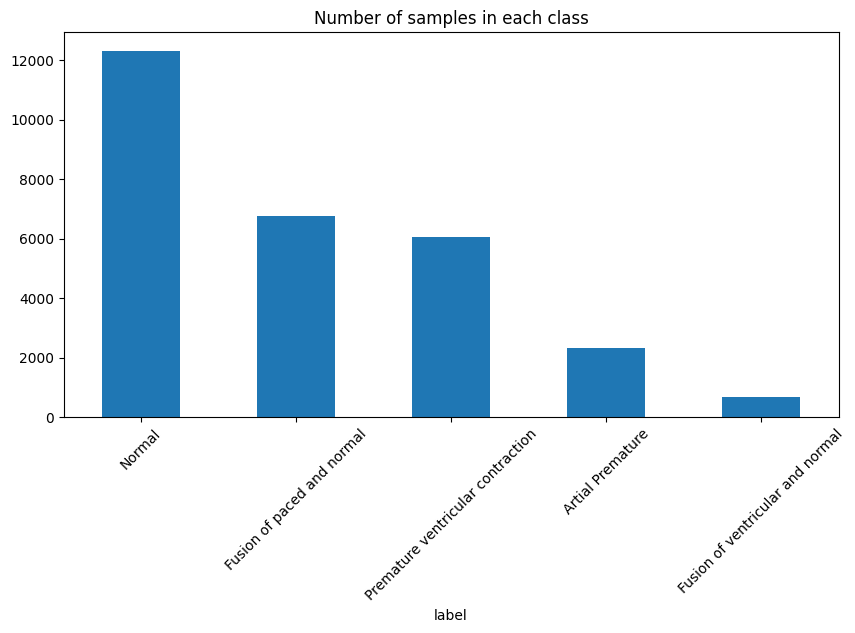

In [224]:
# Load the data
df_mitbih_train = pd.read_csv("/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/src/data/mitbih_train.csv", header=None)
df_mitbih_test = pd.read_csv("/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/src/data/mitbih_test.csv", header=None)

# Print shapes of the dataframes
print("The shape of the mitbih_train is:", df_mitbih_train.shape)
print("The shape of the mitbih_test is:", df_mitbih_test.shape)

# Concatenate train and test dataframes
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

# Define id_to_label mapping
id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# Get the number of columns in the dataframe
num_cols = df_mitbih.shape[1] - 1 
# Compute the time vector
time = np.arange(0, num_cols) / 125
# Convert to milliseconds
time = time * 1000
# Print last time value
print("The last time value is:", time[-1])

# Rename the columns
df_mitbih.columns = list(time) + ["label"]

# Remove 85% of the values from normal
normal_entries = df_mitbih[df_mitbih['label'] == 0]
num_to_remove = int(0.80 * len(normal_entries))
indices_to_remove = np.random.choice(normal_entries.index, num_to_remove, replace=False)
df_mitbih = df_mitbih.drop(indices_to_remove)

# Count the number of samples in each class and plot a bar chart
counts = df_mitbih["label"].value_counts()
counts.index = counts.index.map(id_to_label)

# Create a figure and plot a bar chart
plt.figure(figsize=(10, 5))
counts.plot(kind="bar")
plt.xticks(rotation=45)
plt.title("Number of samples in each class")
plt.show()

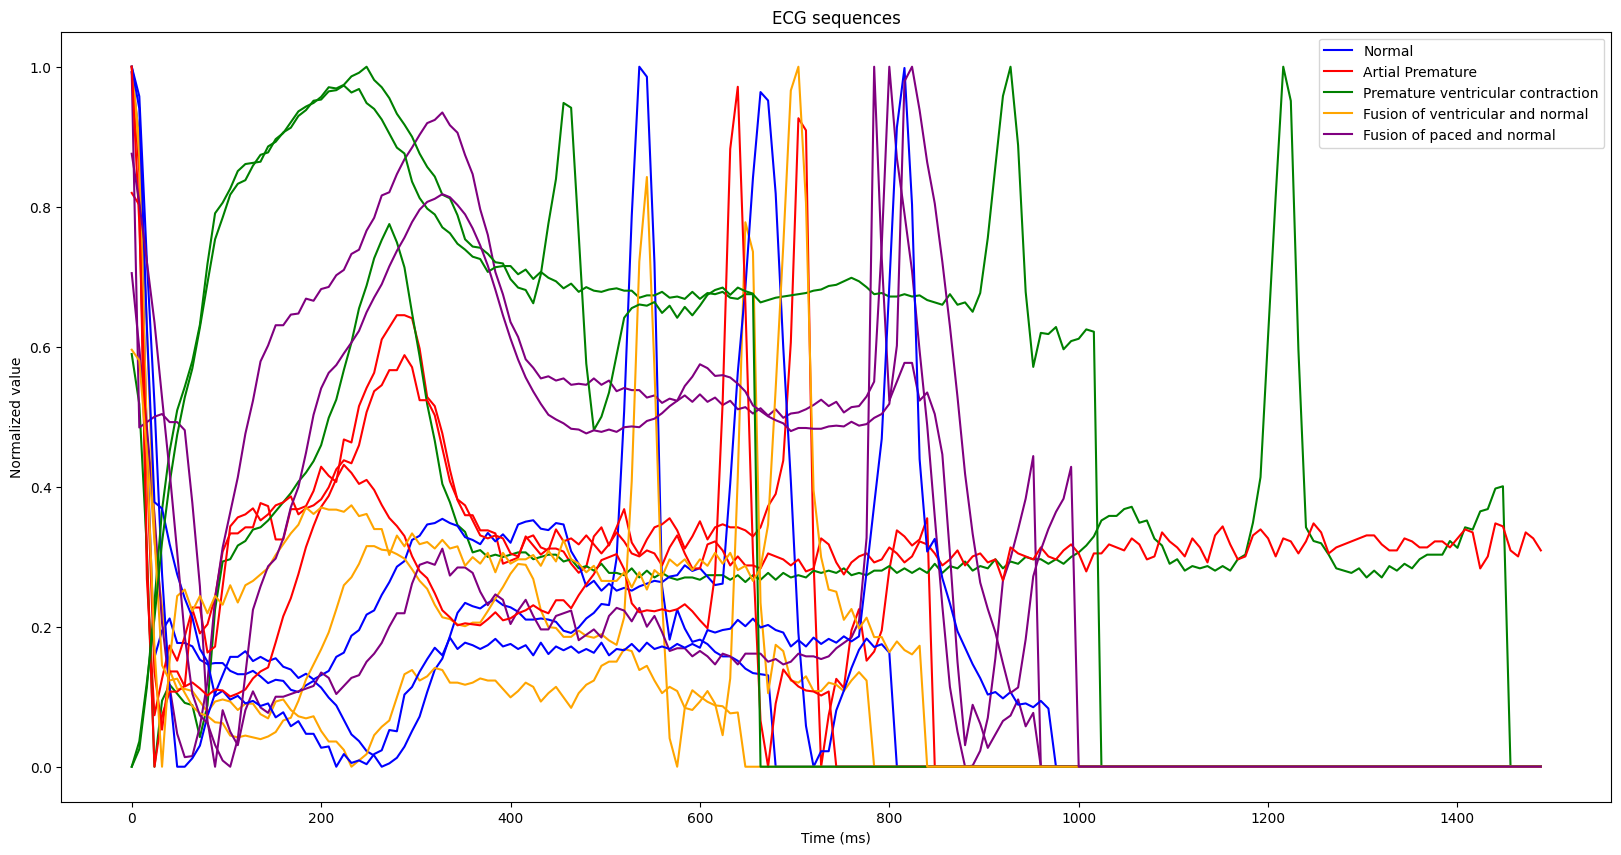

In [225]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [226]:
from sklearn.model_selection import train_test_split

x = df_mitbih.iloc[:, :-1]
y = df_mitbih.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(22510, 187)
(22510, 5)
(2814, 187)
(2814,)
(2814, 187)
(2814, 5)


In [227]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters = 64,kernel_size = 3, activation = "relu", input_shape = (x_train.shape[1],1)),
tf.keras.layers.MaxPooling1D(pool_size = 2),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv1D(filters = 128,kernel_size = 3, activation = "relu"),
tf.keras.layers.MaxPooling1D(pool_size = 2),
tf.keras.layers.Dropout(0.2),
#tf.keras.layers.LSTM(64, return_sequences = True),
#tf.keras.layers.Dropout(0.2),
#tf.keras.layers.LSTM(32),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation = "relu"),
tf.keras.layers.Dense(5, activation = "softmax"),
])

/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [228]:
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss = loss, metrics = ["accuracy"])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss = "categorical_crossentropy", metrics = ["accuracy"])

In [229]:
"""early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # You can change this to 'val_accuracy' if you prefer
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the model from the epoch with the best value of the monitored quantity
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)"""

history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # You can change this to 'val_accuracy' if you prefer
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the model from the epoch with the best value of the monitored quantity
)])

Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7497 - loss: 0.6983 - val_accuracy: 0.8936 - val_loss: 0.3206
Epoch 2/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8899 - loss: 0.3349 - val_accuracy: 0.9160 - val_loss: 0.2525
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9059 - loss: 0.2846 - val_accuracy: 0.9112 - val_loss: 0.2627
Epoch 4/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9145 - loss: 0.2531 - val_accuracy: 0.9300 - val_loss: 0.2104
Epoch 5/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9205 - loss: 0.2457 - val_accuracy: 0.9263 - val_loss: 0.2336
Epoch 6/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9251 - loss: 0.2241 - val_accuracy: 0.9320 - val_loss: 0.2154
Epoch 7/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9313 - loss: 0.2083 - val_accuracy: 0.9374 - val_loss: 0.1984
Epoch 8/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9347 - loss: 0.1990 - val_acc

Epoch 1/10


/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.5868 - loss: 1.0559 - val_accuracy: 0.8191 - val_loss: 0.5013
Epoch 2/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7878 - loss: 0.6060 - val_accuracy: 0.8627 - val_loss: 0.4134
Epoch 3/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8237 - loss: 0.5200 - val_accuracy: 0.8729 - val_loss: 0.3635
Epoch 4/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.8347 - loss: 0.4783 - val_accuracy: 0.8875 - val_loss: 0.3333
Epoch 5/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.8458 - loss: 0.4468 - val_accuracy: 0.8879 - val_loss: 0.3196
Epoch 6/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.8572 - loss: 0.4083 - val_accuracy: 0.8945 - val_loss: 0.3052
Epoch 7/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.8648 - loss: 0.4002 - val_accuracy: 0.8928 - val_loss: 0.3078
Epoch 8/10
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.8678 - loss: 0.3924 - val_accuracy:

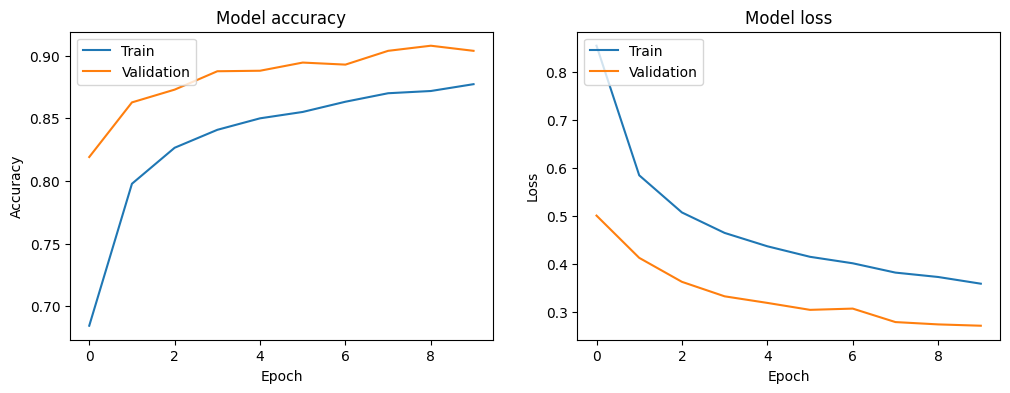

In [230]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the data
df_mitbih_train = pd.read_csv("/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/src/data/mitbih_train.csv", header=None)
df_mitbih_test = pd.read_csv("/Users/lorenzogonzalez/Downloads/LNLL Data Challenge/src/data/mitbih_test.csv", header=None)

# Concatenate train and test dataframes
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

# Remove 85% of the values from normal
normal_entries = df_mitbih[df_mitbih['label'] == 0]
num_to_remove = int(0.85 * len(normal_entries))
indices_to_remove = np.random.choice(normal_entries.index, num_to_remove, replace=False)
df_mitbih = df_mitbih.drop(indices_to_remove)

# Split the data into features and labels
X = df_mitbih.iloc[:, :-1].values
y = df_mitbih['label'].values

# Convert labels to one-hot encoding
y = to_categorical(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data = (X_val,y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()